In [7]:
from datasets import load_dataset
from utils import Evaluator
from transformers import AutoTokenizer

/home/pferrazzi/LS-LLaMA-E3C/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LOAD BEST MODEL RESULTS

In [8]:
import pandas as pd
from datasets import Dataset

class Evaluator():
    def __init__(self, data, tokenizer):
        self.data = data
        # self.evaluation_table = pd.DataFrame(columns=['TP', 'FP', 'FN'])
        self.evaluation_table = {}
        self.tokenizer = tokenizer
        
     
    def _compare_prediction_label_one_example_token_by_token(self, example) -> (int, int, int):
        """
        Compare the prediction with the label of one sentence.
        Args:
        predictions (list[str]): the list of the predicted labels
        labels (list[str]): the list of the true labels
        return:
        int: the number of false positives
        int: the number of false negatives
        int: the number of true positives
        """
        predictions = example['predictions']
        labels = example['ground_truth_labels']
        TP, FP, FN = 0, 0, 0
        # labels = ['O'] + labels[:-1] 
        for pred, lab in zip(predictions, labels):
            TP = TP + (1 if pred == lab and lab!='O' else 0)
            FP = FP + (1 if pred != lab and lab =='O' else 0)
            FN = FN + (1 if pred != lab and pred =='O' else 0)
        TN = len(predictions) - (TP + FP + FN) 
        try:
            precision = TP / (TP + FP)
        except:
            precision = 0
        try:
            recall = TP / (TP + FN)
        except:
            recall = 0
        try:
            f1 = 2 * (precision * recall) / (precision + recall)
        except:
            f1 = 0
        
        example['TP'] = TP
        example['FP'] = FP
        example['FN'] = FN
        example['TN'] = TN
        example['precision'] = precision
        example['recall'] = recall
        example['f1'] = f1
        return example
    
    def extract_FP_FN_TP_TN_token_by_token(self) -> (int, int, int):
        """
        Extract the number of False Positives, False Negatives and True Positives from the model output and the ground truth.
        Args:
        predictions (list[str]): the list of the predicted labels
        labels (list[str]): the list of the true labels
        return:
        int: the number of false positives
        int: the number of false negatives
        int: the number of true positives
        """
        self.data = self.data.map(self._compare_prediction_label_one_example_token_by_token, batched=False)


    def create_evaluation_table(self, input_data:Dataset = None):
        """
        Create the evaluation table with the number of False Positives, False Negatives and True Positives.

        Args:
        input_data (Dataset): the dataset to evaluate. If None, the data used to initialize the class is used.

        Returns:
        dict: the evaluation table with the number of False Positives, False Negatives and True Positives.
        """
        if input_data is not None:
            tmp_data = input_data
        else:
            tmp_data = pd.DataFrame(self.data)
        TP = tmp_data['TP'].sum()
        FP = tmp_data['FP'].sum()
        FN = tmp_data['FN'].sum()
        TN = tmp_data['TN'].sum()
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * (precision * recall) / (precision + recall)
        self.evaluation_table = {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
                                  'precision':precision, 'recall':recall, 'f1':f1}
        
        return self.evaluation_table
    


In [9]:
checkpoint = "ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_16_32_0.05_2_0.0002_3EpochsLast"
data = load_dataset(checkpoint, split="test")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
eval = Evaluator(data, tokenizer)
eval.extract_FP_FN_TP_TN_token_by_token()
print(eval.data)
eval.create_evaluation_table()
print(eval.evaluation_table)

Dataset({
    features: ['sentence', 'entities', 'original_text', 'original_id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels', 'predictions', 'ground_truth_labels', 'TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'f1'],
    num_rows: 681
})
{'TP': 7085, 'FP': 1438, 'FN': 3409, 'TN': 8594, 'precision': 0.8312800657045641, 'recall': 0.6751477034495903, 'f1': 0.7451227848766893}


In [62]:
import re
    
class ErrorAnalyst():

    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def get_examples_based_on_metric(self, metric, upper_threshold=1, lower_threshold=0):
        """
        Select the examples based on the metric and the threshold.
        Args:
        metric (str): the metric to consider
        threshold (float): the threshold to consider
        return:
        list: the list of examples that satisfy the condition
        """
        out = [example for example in self.data if example[metric] <= upper_threshold and example[metric] >= lower_threshold]
        return(Dataset.from_pandas(pd.DataFrame(out)))
    
    def print_formatted_data(self, data):
        """
        Print the data in a human readable format.
        """
        for example in data:
            sentence_pred = example['predictions']
            sentence = example['sentence']
            tokenized_input = self.tokenizer(sentence, add_special_tokens=False)
            tokens = self.tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
            print("LUNGHEZZA:", len(tokens))
            print(f"{sentence}\n{[(t,p, ground_truth_label) for t, p, ground_truth_label in zip(tokens, sentence_pred, example['ground_truth_labels'])]}")

    def print_disallined_Is(self):
        """
        """
        counter = 0
        tot_tokens = 0
        print('(token, prediction, ground_truth_label)')
        self.disallined_df = pd.DataFrame(columns=['id', 'token', 'prediction', 'ground_truth_label'])
        id_sentence = 0
        for example in self.data:
            sentence_pred = example['predictions']
            sentence = example['sentence']
            previous = '' 
            appened = False
            for token in sentence_pred:
                if token=='I' and previous=='O':
                    appened = True
                    counter+=1
                    # print('token:', token, 'previous:', previous, 'position:', i, 'sentence:', sentence_pred)
                previous = token
                tot_tokens += 1
            if appened:
                tokenized_input = self.tokenizer(sentence, add_special_tokens=False)
                tokens = self.tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
                self.disallined_df = pd.concat([self.disallined_df, pd.DataFrame([{'id': id_sentence,'token':t, 'prediction': p, 'ground_truth_label': ground_truth_label} for t, p, ground_truth_label in zip(tokens, sentence_pred, example['ground_truth_labels'])])])
                print([(t,p, ground_truth_label) for t, p, ground_truth_label in zip(tokens, sentence_pred, example['ground_truth_labels'])])
                id_sentence += 1
    
    def split_sentence_into_tokens(self, sentence):
        """
        """
        tokenized_input = self.tokenizer(sentence, add_special_tokens=False)
        tokens = self.tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
        return(tokens)

    def _extract_multitoken_words_from_example(self, example, n_tokens_threshold_lower, n_tokens_threshold_upper):
        """
        """
        sentence = example['sentence']
        tokens = self.split_sentence_into_tokens(sentence)
        multitoken_words = []
        multitoken_word = ''
        token_counter = 0
        interesting_token_mask = [0]*len(tokens)
        for i, token in enumerate(tokens):
            if token.startswith('▁'):
                if token_counter >= n_tokens_threshold_lower and token_counter <= n_tokens_threshold_upper:
                    multitoken_words.append(multitoken_word)
                    interesting_token_mask[i-token_counter:i] = [1]*token_counter
                multitoken_word = token[1:]
                token_counter = 1
            else:
                multitoken_word += token
                token_counter += 1

        if token_counter >= n_tokens_threshold_lower and token_counter <= n_tokens_threshold_upper:
            multitoken_words.append(multitoken_word)
            interesting_token_mask[-token_counter:] = [1]*token_counter
        example[f'multitoken_words'] = multitoken_words
        example[f'interesting_token_mask'] = interesting_token_mask
        return example

    def get_sentences_with_multitoken_words(self, n_tokens_threshold_lower, n_tokens_threshold_upper):
        """
        """
        out = self.data.map(lambda example: self._extract_multitoken_words_from_example(example, n_tokens_threshold_lower, n_tokens_threshold_upper))
        out = out.filter(lambda example: len(example[f'multitoken_words'])>0)
        return out

    # def get_sentences_without_multitoken_words(self, n_tokens_threshold):
    #     """
    #     """
    #     out = self.data.map(lambda example: self._extract_multitoken_words_from_example(example, n_tokens_threshold))
    #     out = out.filter(lambda example: len(example[f'multitoken_words_{n_tokens_threshold}'])==0)
    #     return out
    
    def get_multitokens_words(self, n_tokens_threshold_lower, n_tokens_threshold_upper):
        """
        """
        out = self.get_sentences_with_multitoken_words( n_tokens_threshold_lower, n_tokens_threshold_upper)

        def helper(example):
            interesting_token_mask = example[f'interesting_token_mask']
            attention_mask = [bit for bit, mask in zip(example['attention_mask'], interesting_token_mask) if mask==1]
            labels = [bit for bit, mask in zip(example['labels'], interesting_token_mask) if mask==1]
            predictions = [bit for bit, mask in zip(example['predictions'], interesting_token_mask) if mask==1]
            ground_truth_labels = [bit for bit, mask in zip(example['ground_truth_labels'], interesting_token_mask) if mask==1]
            input_ids = [bit for bit, mask in zip(example['input_ids'], interesting_token_mask) if mask==1]
            sentence = tokenizer.decode(input_ids)
            new_example= {'sentence': sentence, 'attention_mask': attention_mask, 'input_ids': input_ids, 'labels': labels, 'predictions': predictions, 'ground_truth_labels': ground_truth_labels}
            return new_example
    
        out = out.map(helper, remove_columns=['TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'f1', 'ner_tags', 'tokens', f'interesting_token_mask'])
        return out
    
    def get_multitokens_words_without_numbers(self, n_tokens_threshold_lower, n_tokens_threshold_upper):
        """
        """
        out = self.get_multitokens_words(n_tokens_threshold_lower, n_tokens_threshold_upper)
        out = out.filter(lambda example: not any(char.isdigit() for char in example['sentence']))
        return out
    
    def get_multitokens_words_with_numbers(self, n_tokens_threshold_lower, n_tokens_threshold_upper):
        """
        """
        out = self.get_multitokens_words(n_tokens_threshold_lower, n_tokens_threshold_upper)
        out = out.filter(lambda example: any(char.isdigit() for char in example['sentence']))
        return out

err_analist = ErrorAnalyst(eval.data, tokenizer)


##### Questo mostra che avere frasi con parole composte da tanti token non peggiora le performances: f1 solo sulle frasi con almeno una parola composta da almeno 6 token è praticamente uguale a quella complessiva

In [53]:
data_with_multitoken_worsd_4 = err_analist.get_sentences_with_multitoken_words(6, 100)
eval_with_multitoken_worsd_4 = Evaluator(data_with_multitoken_worsd_4, tokenizer)
eval_with_multitoken_worsd_4.extract_FP_FN_TP_TN_token_by_token()
print("WITH:    ", eval_with_multitoken_worsd_4.create_evaluation_table())

data_without_multitoken_worsd_4 = err_analist.get_sentences_with_multitoken_words(0, 5)
eval_without_multitoken_worsd_4 = Evaluator(data_without_multitoken_worsd_4, tokenizer)
eval_without_multitoken_worsd_4.extract_FP_FN_TP_TN_token_by_token()
print("WITHOUT: ", eval_without_multitoken_worsd_4.create_evaluation_table())

WITH:     {'TP': 2772, 'FP': 501, 'FN': 1202, 'TN': 3032, 'precision': 0.846929422548121, 'recall': 0.6975339708102667, 'f1': 0.765006209465986}


Map: 100%|██████████| 681/681 [00:00<00:00, 3891.46 examples/s]


WITHOUT:  {'TP': 7085, 'FP': 1438, 'FN': 3409, 'TN': 8594, 'precision': 0.8312800657045641, 'recall': 0.6751477034495903, 'f1': 0.7451227848766893}


##### vediamo se le parole stesse composte da molti token (e non le frasi intere, ma solo e soltanto le parole) sono missclassificate. La risposta è: NO, anzi. Le parole lunghe sono ben assegante

In [57]:
data_with_multitoken_worsd_6 = err_analist.get_multitokens_words(6, 100)
eval_with_multitoken_worsd_6 = Evaluator(data_with_multitoken_worsd_6, tokenizer)
eval_with_multitoken_worsd_6.extract_FP_FN_TP_TN_token_by_token()
eval_with_multitoken_worsd_6.create_evaluation_table()

Map:   0%|          | 0/681 [00:00<?, ? examples/s]

Map: 100%|██████████| 177/177 [00:00<00:00, 6170.71 examples/s]


{'TP': 932,
 'FP': 92,
 'FN': 220,
 'TN': 484,
 'precision': 0.91015625,
 'recall': 0.8090277777777778,
 'f1': 0.8566176470588236}

##### ci sono 2 tipi di parole lunghe: quelle composte da numeri e quelle che sono vere e proprie parole. Qui si vede che le parole vere r e proprie hanno performances peggiori (molto) di quelle che contengono numeri. La parte di interesse è quindi dire che i numeri lunghi vengono classificati molto bene, le parole lunghe nella media.

In [64]:
data_with_multitoken_worsd_6 = err_analist.get_multitokens_words_with_numbers(6, 100)
eval_with_multitoken_worsd_6 = Evaluator(data_with_multitoken_worsd_6, tokenizer)
eval_with_multitoken_worsd_6.extract_FP_FN_TP_TN_token_by_token()
print("many tokens containing numbers: ",eval_with_multitoken_worsd_6.create_evaluation_table())
      
data_with_multitoken_worsd_6 = err_analist.get_multitokens_words_without_numbers(6, 100)
eval_with_multitoken_worsd_6 = Evaluator(data_with_multitoken_worsd_6, tokenizer)
eval_with_multitoken_worsd_6.extract_FP_FN_TP_TN_token_by_token()
print("many tokens NOT containing numbers: ",eval_with_multitoken_worsd_6.create_evaluation_table())

Map:   0%|          | 0/681 [00:00<?, ? examples/s]

Map: 100%|██████████| 86/86 [00:00<00:00, 4398.15 examples/s]


many tokens containing numbers:  {'TP': 667, 'FP': 49, 'FN': 79, 'TN': 233, 'precision': 0.9315642458100558, 'recall': 0.8941018766756033, 'f1': 0.9124487004103967}


Map: 100%|██████████| 91/91 [00:00<00:00, 4322.21 examples/s]


many tokens NOT containing numbers:  {'TP': 265, 'FP': 43, 'FN': 141, 'TN': 251, 'precision': 0.8603896103896104, 'recall': 0.6527093596059114, 'f1': 0.7422969187675069}


In [65]:
print(data_with_multitoken_worsd_6['sentence'][:10])

['atrioventricular', 'hemoperitoneum.', 'anti-tuberculosis', 'lobo-isthmectomy,', 'Transthoracic', 'chondromatosis)', 'Antero-posterior', 'μg/L; μg/L;', 'Lymphadenopathy', 'non-contributory.']


##### vediamo come vanno le performances dato il numero di token da cui le parole sono composte. Si vede che il modello assegna bene parole lunghe, ma male parole corte

Threshold: 0 {'TP': 1093, 'FP': 162, 'FN': 1026, 'TN': 4676, 'precision': 0.8709163346613545, 'recall': 0.515809344030203, 'f1': 0.6478956727919384}
Threshold: 1 {'TP': 2631, 'FP': 558, 'FN': 1742, 'TN': 6004, 'precision': 0.8250235183443085, 'recall': 0.6016464669563228, 'f1': 0.6958476593493784}
Threshold: 2 {'TP': 3258, 'FP': 762, 'FN': 1354, 'TN': 2310, 'precision': 0.8104477611940298, 'recall': 0.7064180398959237, 'f1': 0.7548656163113994}
Threshold: 3 {'TP': 2829, 'FP': 642, 'FN': 1139, 'TN': 1674, 'precision': 0.8150388936905791, 'recall': 0.7129536290322581, 'f1': 0.760586100282296}
Threshold: 4 {'TP': 1802, 'FP': 422, 'FN': 809, 'TN': 1124, 'precision': 0.810251798561151, 'recall': 0.6901570279586365, 'f1': 0.745398138572906}
Threshold: 5 {'TP': 1036, 'FP': 192, 'FN': 451, 'TN': 650, 'precision': 0.8436482084690554, 'recall': 0.6967047747141897, 'f1': 0.7631675874769798}
Threshold: 6 {'TP': 627, 'FP': 62, 'FN': 177, 'TN': 367, 'precision': 0.9100145137880987, 'recall': 0.77985

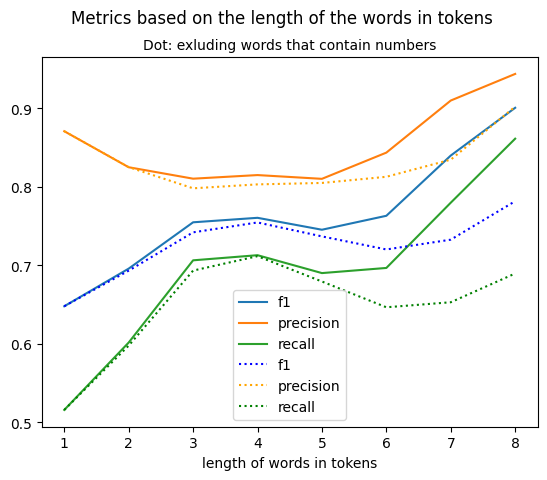

[681, 618, 529, 475, 356, 191, 83, 39]

In [95]:
f1 = []
precision = []
recall = []
n_tokens_threshold = []
n_rows = []
for threshold in range(8):
    data_tmp = err_analist.get_multitokens_words(threshold, threshold+1)
    eval_tmp = Evaluator(data_tmp, tokenizer)
    eval_tmp.extract_FP_FN_TP_TN_token_by_token()
    eval_tmp.create_evaluation_table()
    print(f"Threshold: {threshold}", eval_tmp.evaluation_table)
    n_tokens_threshold.append(threshold+1)
    f1.append(eval_tmp.evaluation_table['f1'])
    precision.append(eval_tmp.evaluation_table['precision'])
    recall.append(eval_tmp.evaluation_table['recall'])
    n_rows.append(len(data_tmp))

import matplotlib.pyplot as plt
plt.plot(n_tokens_threshold, f1, label='f1')
plt.plot(n_tokens_threshold, precision, label='precision')
plt.plot(n_tokens_threshold, recall, label='recall')
#plt.show()
n_rows

f1 = []
precision = []
recall = []
n_tokens_threshold = []
n_rows = []
for threshold in range(8):
    data_tmp = err_analist.get_multitokens_words_without_numbers(threshold, threshold+1)
    eval_tmp = Evaluator(data_tmp, tokenizer)
    eval_tmp.extract_FP_FN_TP_TN_token_by_token()
    eval_tmp.create_evaluation_table()
    print(f"Threshold: {threshold}", eval_tmp.evaluation_table)
    n_tokens_threshold.append(threshold+1)
    f1.append(eval_tmp.evaluation_table['f1'])
    precision.append(eval_tmp.evaluation_table['precision'])
    recall.append(eval_tmp.evaluation_table['recall'])
    n_rows.append(len(data_tmp))

import matplotlib.pyplot as plt
plt.plot(n_tokens_threshold, f1, label='f1',linestyle=':', color='blue')
plt.plot(n_tokens_threshold, precision, label='precision',linestyle=':', color='orange')
plt.plot(n_tokens_threshold, recall, label='recall',linestyle=':', color='green')
#plt.xlabel('length of words in tokens')
#plt.title('Metrics for NO NUMBERS based on the length of the words in tokens')
plt.xlabel('length of words in tokens')
plt.legend()
plt.suptitle('Metrics based on the length of the words in tokens')
plt.title('Dot: exluding words that contain numbers', fontsize=10)  # Main title

plt.legend()
plt.show()
n_rows


# f1 = []
# precision = []
# recall = []
# n_tokens_threshold = []
# n_rows = []
# for threshold in range(8):
#     try: 
#         data_tmp = err_analist.get_multitokens_words_with_numbers(threshold, threshold+1)
#         eval_tmp = Evaluator(data_tmp, tokenizer)
#         eval_tmp.extract_FP_FN_TP_TN_token_by_token()
#         eval_tmp.create_evaluation_table()
#         print(f"Threshold: {threshold}", eval_tmp.evaluation_table)
#         n_tokens_threshold.append(threshold+1)
#         f1.append(eval_tmp.evaluation_table['f1'])
#         precision.append(eval_tmp.evaluation_table['precision'])
#         recall.append(eval_tmp.evaluation_table['recall'])
#         n_rows.append(len(data_tmp))
#     except:
#         print(f"Threshold: {threshold} not possible")

# import matplotlib.pyplot as plt
# plt.plot(n_tokens_threshold, f1, label='f1',linestyle=':',)
# plt.plot(n_tokens_threshold, precision, label='precision',linestyle=':',)
# plt.plot(n_tokens_threshold, recall, label='recall', linestyle=':',)
# plt.xlabel('length of words in tokens')
# plt.title('Metrics for ONLY NUMBERS based on the length of the words in tokens')
# plt.legend()
# plt.show()
# n_rows



##### qui si vede la distribuzione della proporzione di TP, FN e FP per frase. I TP sono magari normali, gli altri qualcosa tipo gamma

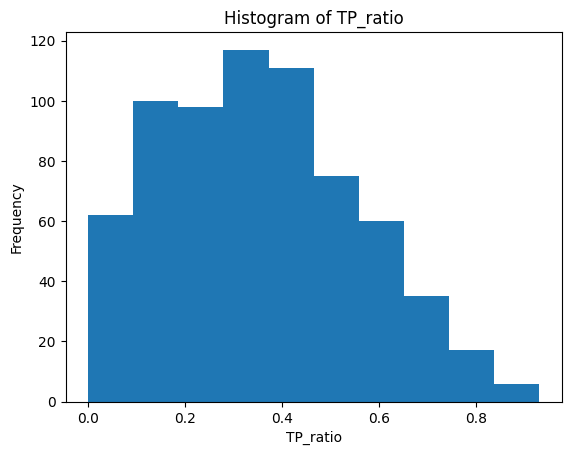

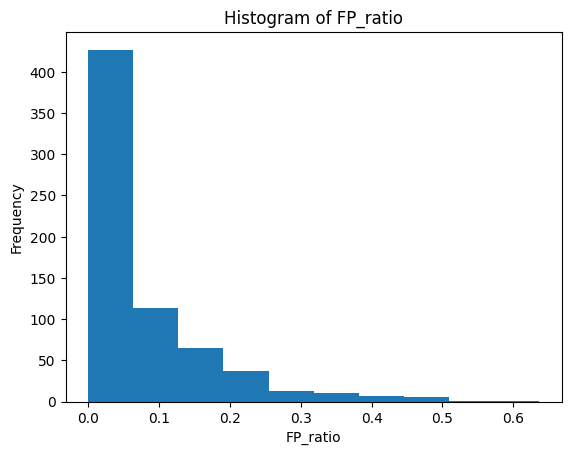

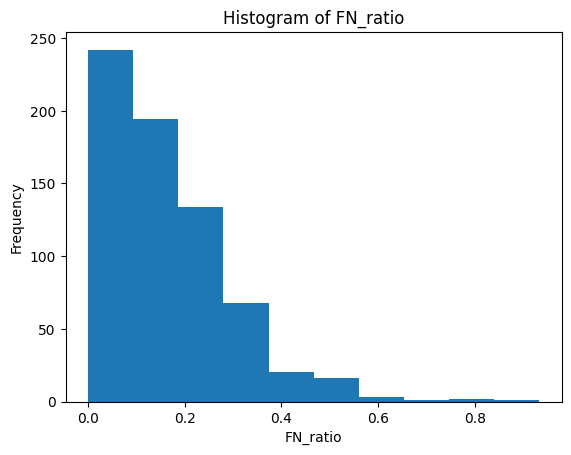

In [16]:
import matplotlib.pyplot as plt


def helper(example):
    example['TP_ratio'] = example['TP'] / len(example['predictions'])
    example['FP_ratio'] = example['FP'] / len(example['predictions'])
    example['FN_ratio'] = example['FN'] / len(example['predictions'])
    return example

tmp = eval.data.map(helper, batched=False)

plt.hist(tmp['TP_ratio'])
plt.xlabel('TP_ratio')
plt.ylabel('Frequency')
plt.title('Histogram of TP_ratio')
plt.show()

plt.hist(tmp['FP_ratio'])
plt.xlabel('FP_ratio')
plt.ylabel('Frequency')
plt.title('Histogram of FP_ratio')
plt.show()

plt.hist(tmp['FN_ratio'])
plt.xlabel('FN_ratio')
plt.ylabel('Frequency')
plt.title('Histogram of FN_ratio')
plt.show()

In [7]:
data_recLower30 = err_analist.get_examples_based_on_metric('recall', lower_threshold=0.05, upper_threshold=0.1)
err_analist.print_formatted_data(data_recLower30)

LUNGHEZZA: 33
The patient was sent home with prednisone and cyclosporine, He was placed on the list of bone marrow transplantation (BMT).
[('▁The', 'O', 'B'), ('▁patient', 'I', 'I'), ('▁was', 'O', 'O'), ('▁sent', 'B', 'O'), ('▁home', 'O', 'B'), ('▁with', 'O', 'O'), ('▁pred', 'O', 'B'), ('nis', 'O', 'I'), ('one', 'O', 'I'), ('▁and', 'O', 'O'), ('▁cy', 'O', 'B'), ('clos', 'O', 'I'), ('por', 'O', 'I'), ('ine', 'O', 'I'), (',', 'O', 'I'), ('▁He', 'O', 'B'), ('▁was', 'O', 'O'), ('▁placed', 'O', 'B'), ('▁on', 'O', 'O'), ('▁the', 'O', 'O'), ('▁list', 'O', 'O'), ('▁of', 'O', 'O'), ('▁b', 'O', 'O'), ('one', 'O', 'O'), ('▁mar', 'O', 'O'), ('row', 'O', 'O'), ('▁trans', 'O', 'O'), ('plant', 'O', 'O'), ('ation', 'O', 'O'), ('▁(', 'O', 'O'), ('B', 'O', 'O'), ('MT', 'O', 'O'), (').', 'O', 'O')]
LUNGHEZZA: 56
An immunohistochemical staining panel was done to determine the nature of this inflammatory infiltrate by using antibodies S-100, CD1a, CD-68 and CD45RO that were positive.
[('▁An', 'O', 'O'), ('

In [34]:
data_precLower30 = eval.get_examples_based_on_metric('precision', lower_threshold=0.05, upper_threshold=0.1)
eval.print_formatted_data(data_precLower30)

LUNGHEZZA: 48
A new genetic variant c.662G > C (p.W221S) in the SERPINC1 gene was detected in proband and affected father but was absent in healthy sister.
[('▁A', 'O', 'O'), ('▁new', 'O', 'O'), ('▁gen', 'O', 'O'), ('etic', 'O', 'O'), ('▁variant', 'O', 'O'), ('▁c', 'B', 'O'), ('.', 'O', 'O'), ('6', 'I', 'O'), ('6', 'I', 'O'), ('2', 'I', 'O'), ('G', 'O', 'O'), ('\u2009', 'I', 'O'), ('>', 'I', 'O'), ('\u2009', 'I', 'O'), ('C', 'O', 'O'), ('▁(', 'B', 'O'), ('p', 'I', 'O'), ('.', 'I', 'O'), ('W', 'B', 'O'), ('2', 'I', 'O'), ('2', 'O', 'O'), ('1', 'O', 'O'), ('S', 'O', 'O'), (')', 'O', 'O'), ('▁in', 'O', 'O'), ('▁the', 'O', 'O'), ('▁SER', 'O', 'O'), ('P', 'O', 'O'), ('IN', 'O', 'O'), ('C', 'O', 'O'), ('1', 'O', 'O'), ('▁gene', 'O', 'B'), ('▁was', 'O', 'O'), ('▁detected', 'O', 'O'), ('▁in', 'O', 'O'), ('▁prob', 'B', 'O'), ('and', 'I', 'B'), ('▁and', 'O', 'I'), ('▁affected', 'I', 'O'), ('▁father', 'I', 'O'), ('▁but', 'O', 'B'), ('▁was', 'O', 'O'), ('▁absent', 'B', 'B'), ('▁in', 'O', 'I'), ('▁

In [30]:
data_f1Lower30 = eval.get_examples_based_on_metric('f1', lower_threshold=0.05, upper_threshold=0.1)
eval.print_formatted_data(data_f1Lower30)

She received a chemotherapy protocol made of hyperalkalinisation, allopurinol, hydroxyurea and a treatment based on imatinib at the dose of 400mg per day.
[('▁She', 'B', 'B'), ('▁received', 'O', 'O'), ('▁a', 'O', 'O'), ('▁chem', 'B', 'O'), ('other', 'O', 'O'), ('apy', 'O', 'O'), ('▁protocol', 'O', 'B'), ('▁made', 'O', 'O'), ('▁of', 'O', 'O'), ('▁hyper', 'O', 'B'), ('alk', 'O', 'I'), ('alin', 'O', 'I'), ('isation', 'O', 'I'), (',', 'O', 'I'), ('▁al', 'O', 'B'), ('lop', 'O', 'I'), ('ur', 'O', 'I'), ('in', 'O', 'I'), ('ol', 'O', 'I'), (',', 'O', 'I'), ('▁hydro', 'O', 'B'), ('xy', 'O', 'I'), ('ure', 'O', 'I'), ('a', 'O', 'I'), ('▁and', 'O', 'O'), ('▁a', 'O', 'O'), ('▁treatment', 'O', 'B'), ('▁based', 'O', 'O'), ('▁on', 'O', 'O'), ('▁im', 'O', 'B'), ('atin', 'O', 'I'), ('ib', 'O', 'I'), ('▁at', 'O', 'O'), ('▁the', 'O', 'O'), ('▁do', 'O', 'O'), ('se', 'O', 'O'), ('▁of', 'O', 'O'), ('▁', 'O', 'O'), ('4', 'O', 'O'), ('0', 'O', 'O'), ('0', 'O', 'O'), ('m', 'O', 'O'), ('g', 'O', 'O'), ('▁per', '